In [1]:
import pandas as pd
import numpy as np 
import plotnine as p9
from mizani.formatters import percent_format


## Step 1: Data set up

In [2]:
#importing the dataset to read as a pandas data frame 
avocado = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\LAB 2\avocado-updated-2020.csv")

There are several aspects of our avocado data frame to break down before moving forward with the analysis. The data represents the date of a single observation that took place and was added to our data. The type is a categorical data type which describes if the avocado was organic or conventional. The region is the city or region in which the avocado was sold in. There are different Hass descriptions for avocados which describe the size between small medium (PLU 4046), large (PLU 4225), and extra-large (PLU 4770). Lastly is the Total Volume column which is the total number of avocados sold for that observation. 

In [3]:
#we need to change PLU VARS names
cleaned_avocado = avocado

cleaned_avocado = cleaned_avocado.rename(columns={"4046": "Small_Medium",
                                                  "4225": "Large", 
                                                  "4770": "Extra_Large"})
                                                

In [4]:
#Geographical names need to be sorted based on things such as cities, states, regions, US
#area: ex Buffalo/ Rochester
#region: ex Great Lakes
#city: ex Boston
#US: Total Us
US = "Total U.S."
cities_metros = [
    "Albany",
    "Atlanta",
    "Baltimore/Washington",
    "Boise",
    "Boston",
    "Buffalo/Rochester",
    "Charlotte",
    "Chicago",
    "Cincinnati/Dayton",
    "Columbus",
    "Dallas/Ft. Worth",
    "Denver",
    "Detroit",
    "Grand Rapids",
    "Harrisburg/Scranton",
    "Hartford/Springfield",
    "Houston",
    "Indianapolis",
    "Jacksonville",
    "Las Vegas",
    "Los Angeles",
    "Louisville",
    "Miami/Ft. Lauderdale",
    "Nashville",
    "New Orleans/Mobile",
    "New York",
    "Orlando",
    "Philadelphia",
    "Phoenix/Tucson",
    "Pittsburgh",
    "Portland",
    "Raleigh/Greensboro",
    "Richmond/Norfolk",
    "Roanoke",
    "Sacramento",
    "San Diego",
    "San Francisco",
    "Seattle",
    "Spokane",
    "St. Louis",
    "Syracuse",
    "Tampa"
]

regions = ["California",
    "South Carolina",
    "Great Lakes",
    "Midsouth",
    "Northeast",
    "Northern New England",
    "Plains",
    "South Central",
    "Southeast",
    "West",
    "West Tex/New Mexico"]

cleaned_avocado["US"]     = cleaned_avocado["geography"].eq(US).astype("int8")
cleaned_avocado["City"]   = cleaned_avocado["geography"].isin(cities_metros).astype("int8")
cleaned_avocado["Region"] = cleaned_avocado["geography"].isin(regions).astype("int8")

## Exercises 
### 3. Which major geographical region sold the most total organic small Hass avocados in 2017? 

In [5]:
regions_2017 = cleaned_avocado[(cleaned_avocado["year"]== 2017) & (cleaned_avocado["Region"] == 1) 
                                & (cleaned_avocado["type"] =="organic")]

In [6]:
Most_by_region = regions_2017.groupby("geography")["Small_Medium"].sum()

maxi =Most_by_region.idxmax()

print("The Region with the most total oraganic, small Hass avocados in 2017 was the " 
+ maxi)

The Region with the most total oraganic, small Hass avocados in 2017 was the West


### 4. Splitting the date variables into month, day, year vars.
#### Computing which month has the highest average volume of avocado sales?

In [7]:
#year column is already in this dataset 

cleaned_avocado["Cleaned Date"] = pd.to_datetime(cleaned_avocado["date"])
cleaned_avocado["Month"] = cleaned_avocado["Cleaned Date"].dt.month
cleaned_avocado["Month_Name"] = cleaned_avocado["Cleaned Date"].dt.month_name()

cleaned_avocado["Day"] = cleaned_avocado["Cleaned Date"].dt.day

In [8]:
vol_month = cleaned_avocado[["Month_Name", "total_volume"]].groupby("Month_Name").mean()
Month_High_Vol = vol_month.idxmax()

print("The month that had the highest average volume of avocados sold was in the month of " + Month_High_Vol["total_volume"])

The month that had the highest average volume of avocados sold was in the month of May


### 5. Which metro area georaphical locations sold the most total avocados?

In [9]:
metro = cleaned_avocado[["Region", "geography", "total_volume"]].groupby("geography").mean()
only_regions = metro[metro["Region"] == 1]

print("The region that sold the most average total volume of avocados was " + only_regions["total_volume"].idxmax())

The region that sold the most average total volume of avocados was West


#### ploting box plots of the top 5 regions in average total volume of avocados 

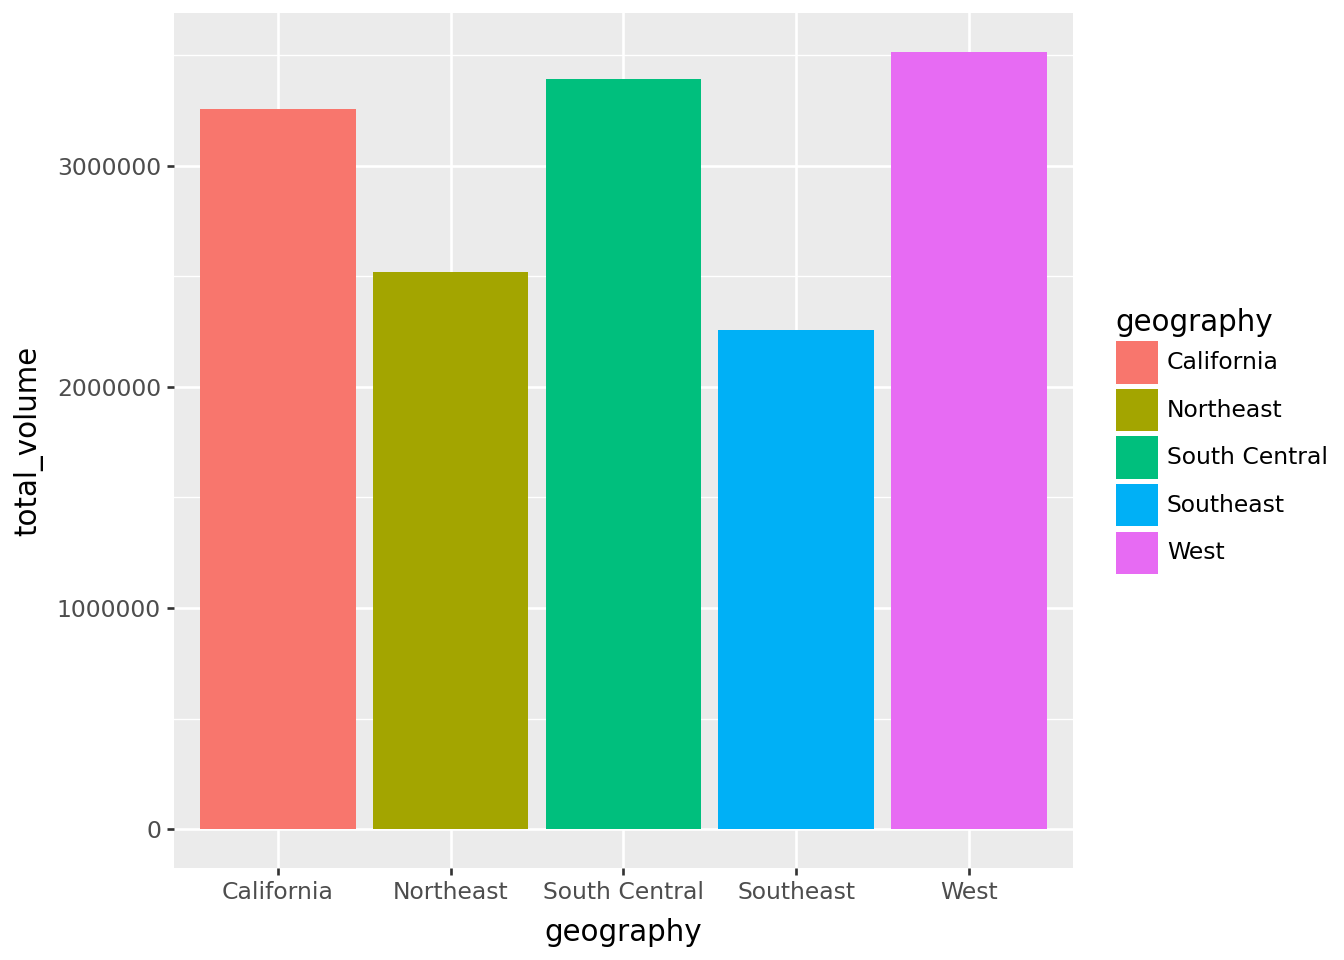

In [10]:
top5 = (only_regions.sort_values(by = ["total_volume"], ascending=False).head(5).reset_index())

(p9.ggplot(top5, p9.aes(x= "geography",y= "total_volume",fill = "geography" ))

+p9.geom_col() )

### 6. Create a cleaned data set with only particular California Regions

In [11]:
cali_cities= cleaned_avocado[(cleaned_avocado["geography"] == "Los Angeles") | (cleaned_avocado["geography"] == "San Diego") |+
(cleaned_avocado["geography"] == "Sacramento") | (cleaned_avocado["geography"] == "San Francisco")]

### 7. in which california regions is the price of organic vs convetrional avocados most different?

In [12]:

group_city = cali_cities.groupby(["type", "geography"])["average_price"].mean().unstack("type").reset_index()

group_city["diff"] = (group_city["conventional"] - group_city["organic"]).abs()

group_city.max()

type
geography       San Francisco
conventional          1.40049
organic              2.119444
diff                 0.718954
dtype: object

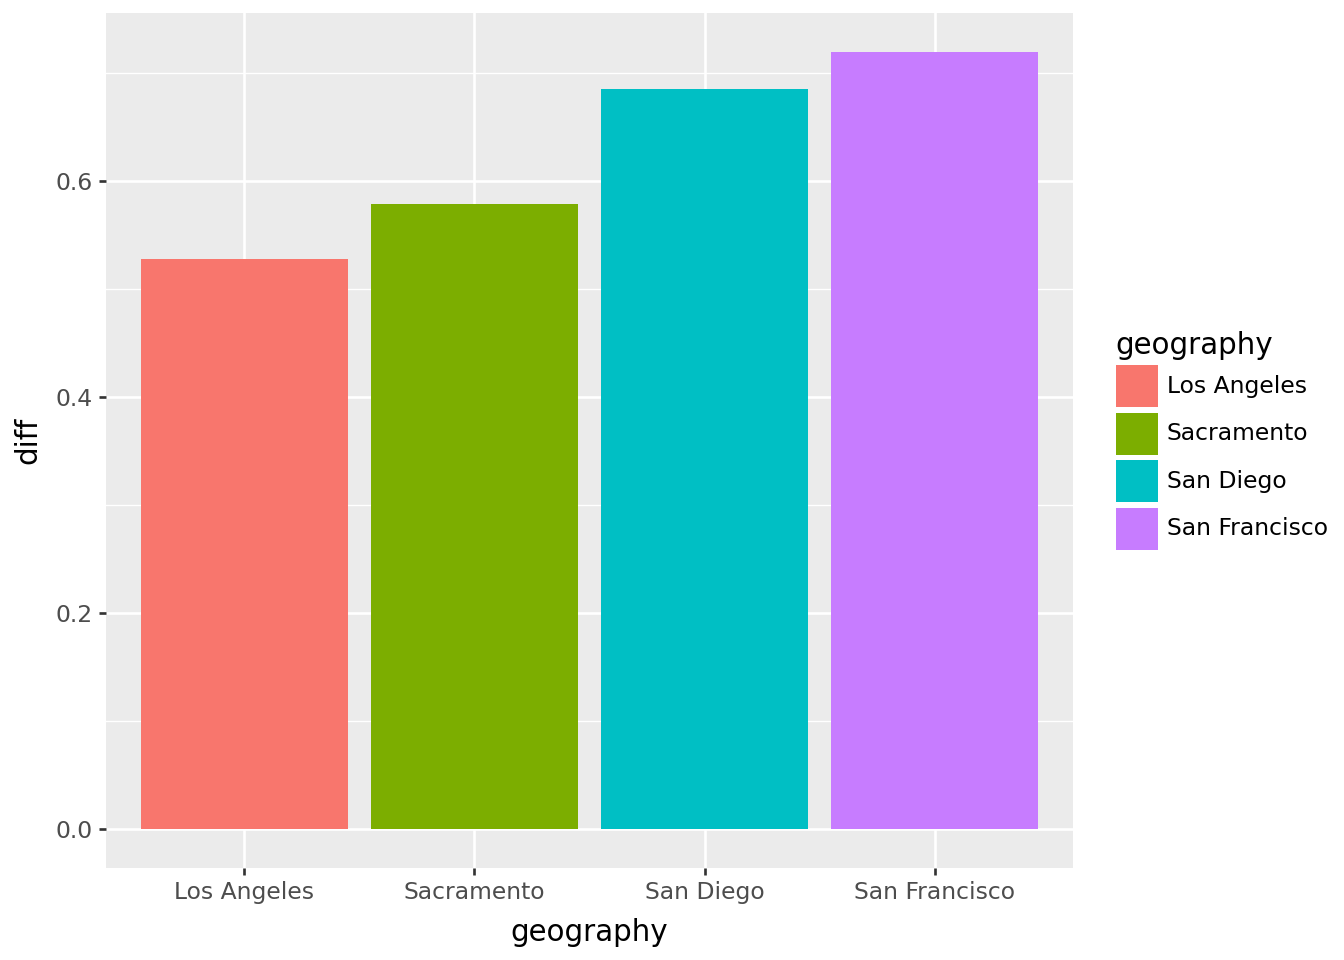

In [13]:
(p9.ggplot(group_city, p9.aes(x = "geography", 
y= "diff", fill = "geography"))

+p9.geom_col() )


### 8. Recreate the plot shown in the lab example

In [14]:
size_4_cities = cali_cities[["type", "Small_Medium", "Large", "Extra_Large", "geography"]]


size_4_cities = (size_4_cities
      .groupby(["geography", "type"])[["Small_Medium", "Large", "Extra_Large"]]
      .sum()
      .reset_index()
      )

size_cols = ["Small_Medium", "Large", "Extra_Large"]
size_4_cities = (
    cali_cities[["geography", "type"] + size_cols]
      .groupby(["geography", "type"], as_index=False)[size_cols]
      .sum()
)

long = size_4_cities.melt(
    id_vars=["geography", "type"],
    value_vars=size_cols,
    var_name="size",
    value_name="sales"
)

long["proportion"] = long.groupby(["geography", "type"])["sales"].transform(
    lambda x: x / x.sum()
)

long["type"] = pd.Categorical(long["type"], ["conventional", "organic"], ordered=True)


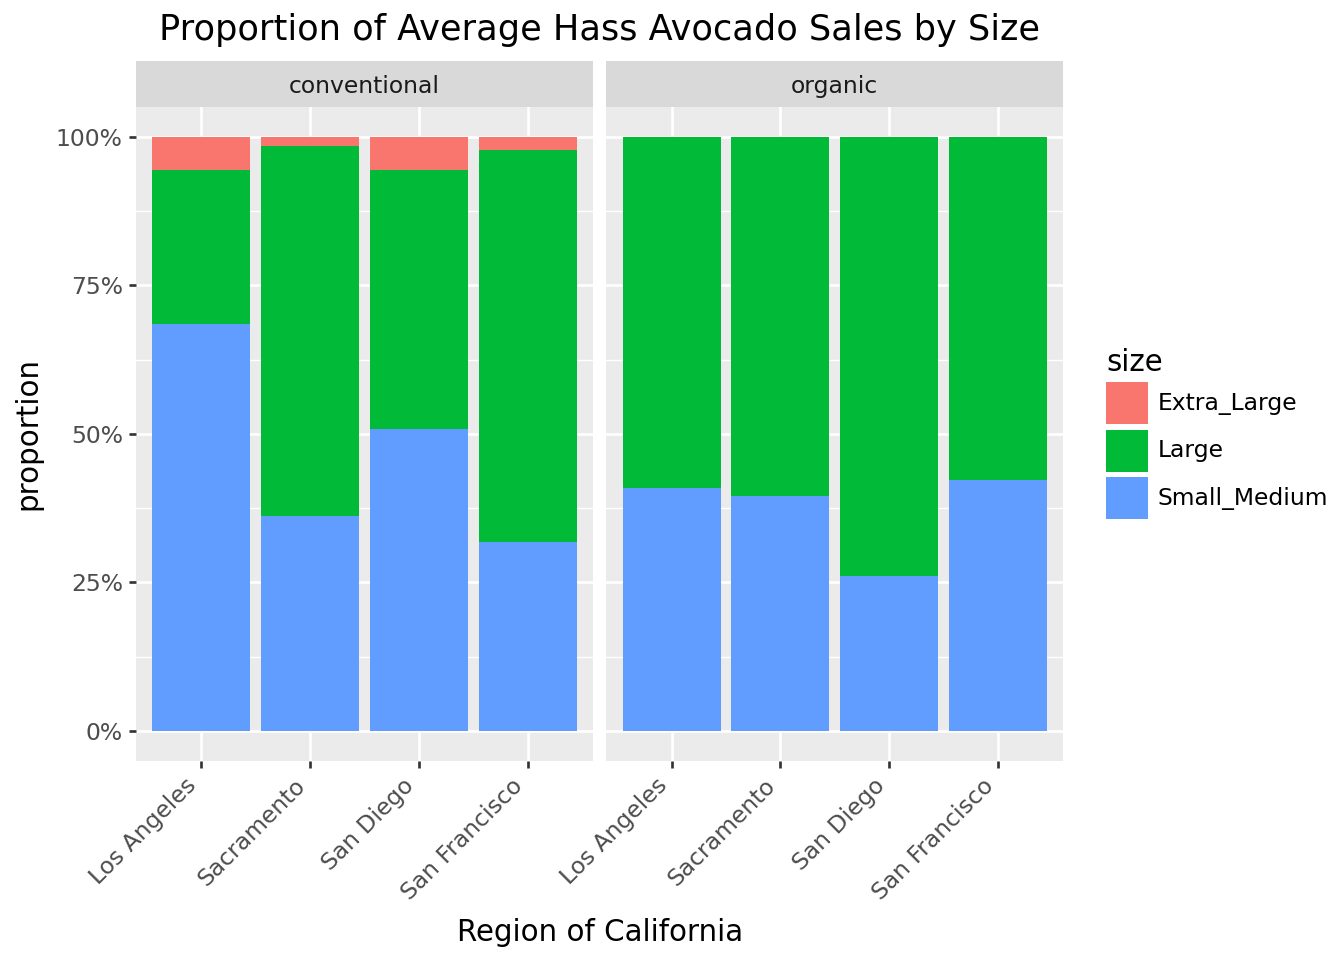

In [15]:
(p9.ggplot(long, p9.aes(x="geography", 
y ="proportion", 
fill = "size"))
+p9.geom_col(position = "fill") \
+p9.facet_wrap("~type", nrow=1) \
+p9.labs(title="Proportion of Average Hass Avocado Sales by Size",
x = "Region of California") \
    +p9.theme(axis_text_x=p9.element_text(angle=45, 
                                 hjust=1,   
                                 vjust=1))\
    +p9.scale_y_continuous(labels = percent_format())
                                 )

## Using outside data 

In [16]:
housing = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\LAB 2\City_MedianRentalPrice_1Bedroom.csv")

CA_City = housing[(housing["RegionName"] == "Los Angeles") |(housing["RegionName"] == "San Diego") |+
(housing["RegionName"] == "Sacramento") | (housing["RegionName"] == "San Francisco")]


date_cols = CA_City.filter(regex=r'^\d{4}-\d{2}$').columns 

CA_City["avg_H_price"] = CA_City[date_cols].replace(0, np.nan).mean(axis=1)

neat = CA_City[["RegionName", "avg_H_price"]]
neat["geography"] = neat["RegionName"]

C:\Users\ldcal\AppData\Local\Temp\ipykernel_28384\2883206396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ldcal\AppData\Local\Temp\ipykernel_28384\2883206396.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
joined = cali_cities.merge(neat)

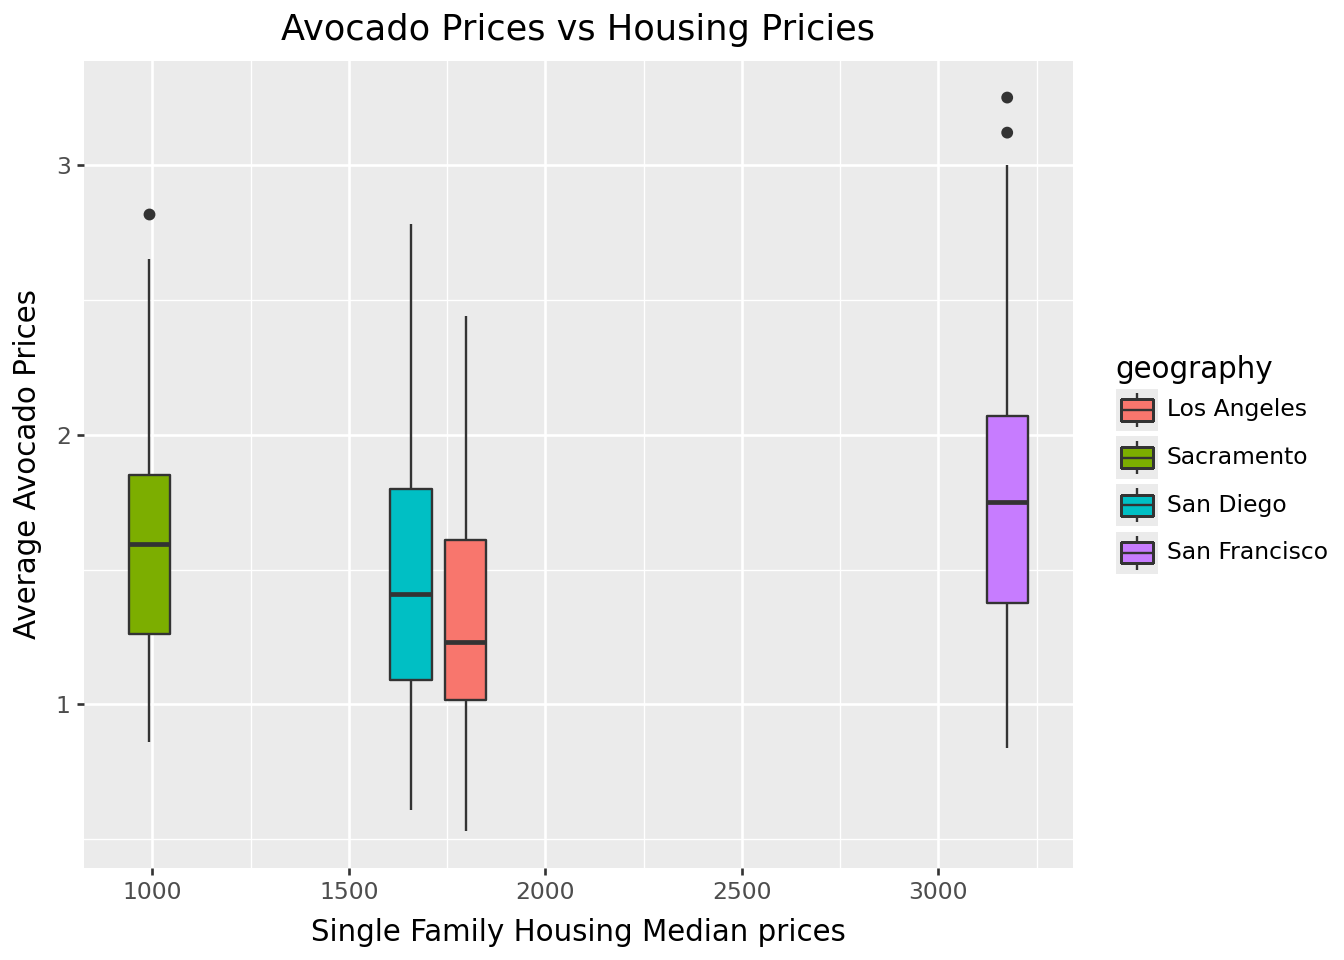

In [18]:
(p9.ggplot(joined, p9.aes(x ="avg_H_price", 
y = "average_price", fill = "geography"))
+p9.geom_boxplot()
+p9.labs(title = "Avocado Prices vs Housing Pricies", 
x = "Single Family Housing Median prices", 
y = "Average Avocado Prices" )
)

Using our data their seems to be very little correaltion between housing prices and avocado prices as most
of our avaerages were closer together in terms of where they live versus how much avocados were. Logically higher 
median priced housing regions like San Francisco will have higher living costs hence the avocado prices being 
slighly higher. 